In [1]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc
import scipy
from tqdm import tqdm, trange
from time import perf_counter

In [2]:
%cd ..
from rputil import *
%cd -

/mnt/c/Users/rishi/GitHub/icerm/random-projections
/mnt/c/Users/rishi/GitHub/icerm/random-projections/notebooks


## Define low-rank approximations

### Singular Value Decomposition

In [3]:
def svd(A, k):
    """Computes the optimal deterministic rank-k approximation of the SVD of the input matrix."""
    U, sigma, Vh = np.linalg.svd(A, full_matrices=False)
    Sigma = np.diag(sigma[:k])
    return U[:,:k] @ Sigma @ Vh[:k]

### Orthogonal Projection Interpolative Decompositions

In [4]:
def opid(A, k):
    """Computes a deterministic rank-k approximation of the OPID of the input matrix."""
    Q, R, P = scipy.linalg.qr(A, pivoting=True, mode='economic')
    Q = Q[:,:k]
    return Q @ Q.T @ A


def random_opid(A, k, oversampling=10, col_pivoted=True, choices=None):
    """Calculates a randomized rank-k approximation of the OPID of the input matrix."""
    
    if oversampling < 0:
        raise ValueError('Oversampling parameter cannot be negative.')
        
    p = k + oversampling
    if p > A.shape[1]:
        raise ValueError('Oversampling parameter is too large.')
    
    if choices is None:
        cols = np.random.choice(A.shape[1], replace=False, size=p)
    else:
        cols = choices
        
    AS = A[:,cols]
    
    if col_pivoted:
        Q, R, _ = scipy.linalg.qr(AS, pivoting=True, mode='economic')
    else:
        Q, R = scipy.linalg.qr(AS, pivoting=False, mode='economic')

    Q = Q[:,:k]  # removes the p-k oversampled columns
    return Q @ Q.T @ A

In [5]:
def ropid_op(A, k):
    return random_opid(A, k, oversampling=10, col_pivoted=True)

def ropid_o(A, k):
    return random_opid(A, k, oversampling=10, col_pivoted=False)

def ropid_p(A, k):
    return random_opid(A, k, oversampling=0, col_pivoted=True)

def ropid_none(A, k):
    return random_opid(A, k, oversampling=0, col_pivoted=False)

In [6]:
def ropid_test(A, k, cols):
    return random_opid(A, k, oversampling=10, col_pivoted=True, choices=cols)

### SciPy Interpolative Decompositions

In [7]:
import scipy.linalg.interpolative as sli

def scipy_id(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=False)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

def scipy_random_id(A, k):
    idx, proj = sli.interp_decomp(A, k, rand=True)
    B = sli.reconstruct_skel_matrix(A, k, idx)
    C = sli.reconstruct_matrix_from_id(B, idx, proj)
    return C

## Read data

In [8]:
import pandas as pd
mnist = pd.read_csv('../datasets/mnist/train.csv')

data = mnist[mnist.columns[1:]].values / 255
data = data[:5000]

Transpose the data matrix if necessary --- we want the matrix to be 'wide' not 'tall'.

In [9]:
if data.shape[0] > data.shape[1]:
    data = data.T

In [10]:
def display_img(A, n):
    choices = np.random.choice(A.shape[1], replace=False, size=n)
    plt.imshow(A[:,choices].reshape(28,28,n).transpose(0,2,1).reshape(28,n*28))

In [11]:
# array.shape = (a,b,c)
# np.transpose(array, (2,0,1)) = (c,a,b)

In [12]:
# display_img(data, 5)

In [13]:
data_norm = np.linalg.norm(data)

In [14]:
def calculate_error(A):
    return np.linalg.norm(data - A) / data_norm

In [15]:
def stats(A):
    res = np.empty(7)
    
    res[0] = np.quantile(A, 0.25)
    res[1] = np.median(A)
    res[2] = np.quantile(A, 0.75)
    res[3] = np.mean(A)
    res[4] = np.std(A)
    res[5] = np.min(A)
    res[6] = np.max(A)
    
    return np.copy(res)

In [16]:
k_domain = np.arange(10, 490, step=40)
k_len = k_domain.shape[0]

### deterministic methods

In [17]:
DET_ALGS = [svd, scipy_id, opid]
num_det_algs = len(DET_ALGS)

DET_ERRORS = np.empty((num_det_algs, k_len))
DET_TIMES = np.empty((num_det_algs, k_len))

for i, k in enumerate(tqdm(k_domain)):
    for h, alg in enumerate(DET_ALGS):
        start = perf_counter()
        DET_ERRORS[h,i] = calculate_error(alg(data, k))
        DET_TIMES[h,i] = perf_counter() - start

100%|██████████| 12/12 [01:06<00:00,  5.56s/it]


### randomized methods

In [18]:
# RAND_ALGS = [scipy_random_id, ropid_op, ropid_o, ropid_p, ropid_none]
RAND_ALGS = [ropid_op, ropid_o, ropid_p, ropid_none]
num_rand_algs = len(RAND_ALGS)

RAND_ERRORS = np.empty((num_rand_algs, 7, k_len))
RAND_TIMES = np.empty((num_rand_algs, 7, k_len))

iterations = 3 #10

for i, k in enumerate(tqdm(k_domain)):
    errors = np.empty((num_rand_algs, iterations))
    times = np.empty((num_rand_algs, iterations))

    for j in range(iterations):
        for h, alg in enumerate(RAND_ALGS):
            start = perf_counter()
            errors[h,j] = calculate_error(alg(data,k))
            times[h,j] = perf_counter() - start
        
    for h in range(num_rand_algs):
        RAND_ERRORS[h,:,i] = stats(errors[h])
        RAND_TIMES[h,:,i] = stats(times[h])

100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


## Display results

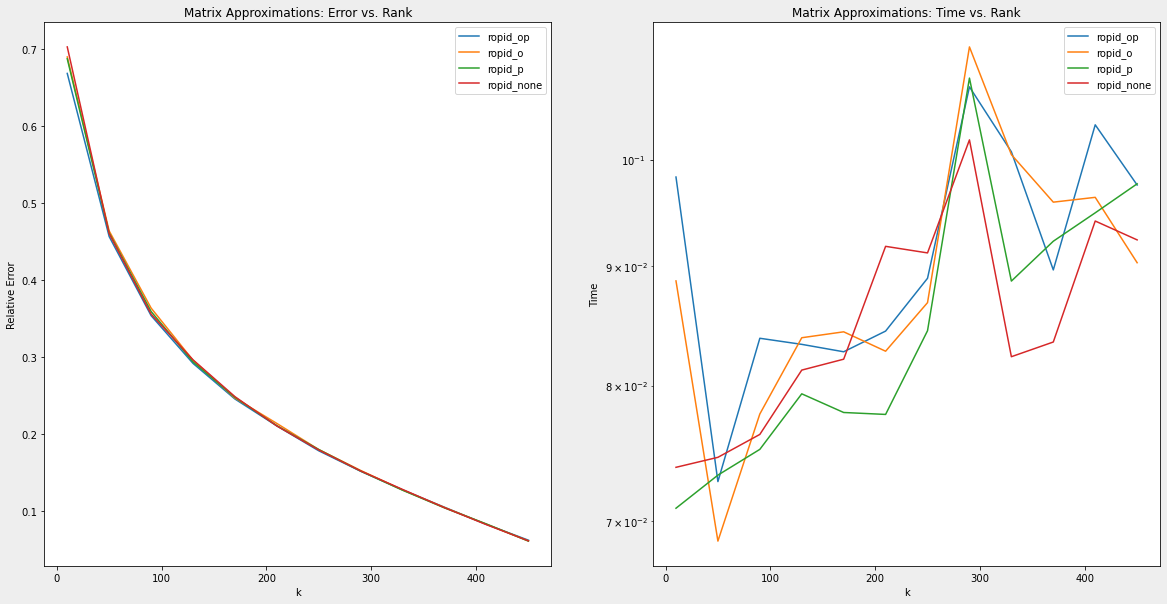

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.set_facecolor('#EEE')


# ERROR GRAPH
# for h, alg in enumerate(DET_ALGS):
#     ax[0].plot(k_domain, DET_ERRORS[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[0].plot(k_domain, RAND_ERRORS[h,3], label=alg.__name__)
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
# ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Matrix Approximations: Error vs. Rank')


# TIME GRAPH
# for h, alg in enumerate(DET_ALGS):
#     ax[1].plot(k_domain, DET_TIMES[h], label=alg.__name__)
for h, alg in enumerate(RAND_ALGS):
    ax[1].plot(k_domain, RAND_TIMES[h,3], label=alg.__name__)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Time')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Matrix Approximations: Time vs. Rank');

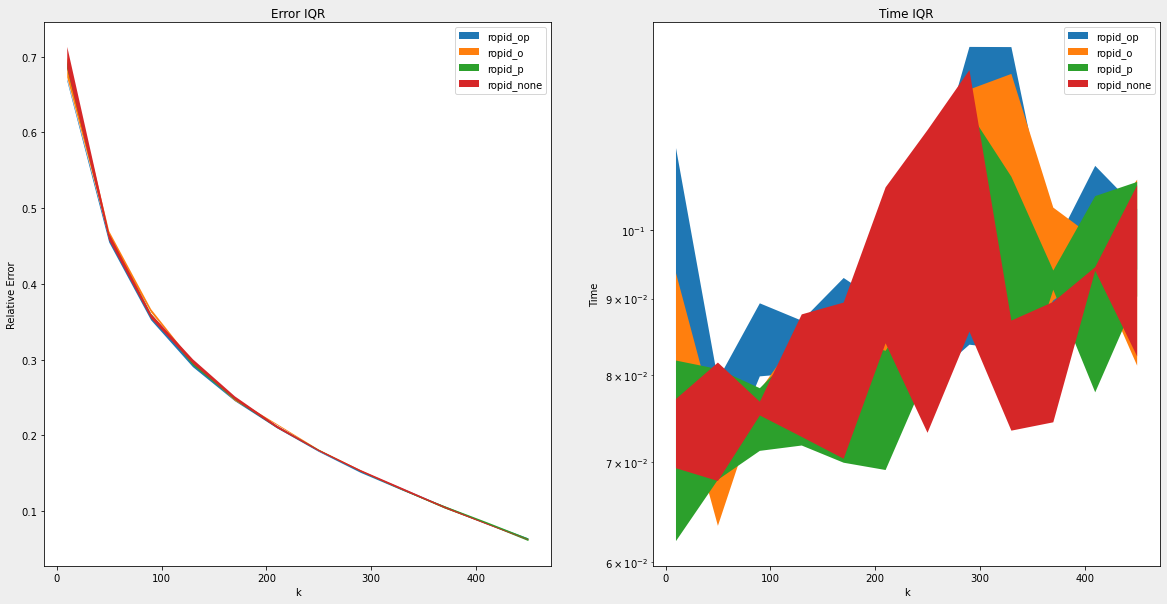

In [20]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.set_facecolor('#EEE')

for h, alg in enumerate(RAND_ALGS):
    ax[0].fill_between(k_domain, RAND_ERRORS[h,5], RAND_ERRORS[h,6], label=alg.__name__)

ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
# ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Error IQR')


for h, alg in enumerate(RAND_ALGS):
    ax[1].fill_between(k_domain, RAND_TIMES[h,5], RAND_TIMES[h,6], label=alg.__name__)

ax[1].set_xlabel('k')
ax[1].set_ylabel('Time')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Time IQR');

### Test to see if low-rank approximation preserves $k$ columns.

In [21]:
temp_k = 200

In [22]:
func = random_opid

In [23]:
cols = np.random.choice(data.shape[1], replace=False, size=temp_k)
approx = func(data, temp_k, choices=cols)

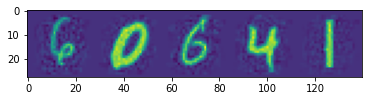

In [24]:
display_img(approx, 5)

In [25]:
eps = 0.00000001

print(f'{np.sum(approx > eps) / approx.size:.1%} of entries are greater than {eps}')

43.8% of entries are greater than 1e-08


In [26]:
print(f'The average value of an entry is {np.mean(approx):.4f}')

The average value of an entry is 0.1309


In [27]:
assert np.allclose(approx[:,cols], data[:,cols]), "This low-rank approximation was not formed from an ID."

In [28]:
np.linalg.matrix_rank(approx, tol=0.001)

200

In [29]:
np.linalg.matrix_rank(data, tol=0.001)

646

### Try to recreate the decomposition from the approximation.

In [30]:
C = approx[:,cols]

In [31]:
res = np.linalg.lstsq(C, approx, rcond=None)
Z = res[0]
print(f'Worst LS residual: {max(res[1])}')

Worst LS residual: 8.846087680159149e-29


In [32]:
np.allclose(C @ Z, approx)

True

In [33]:
np.max(np.abs(Z))

1.0000000000000053